# Constructing physics-based data-driven reduced models for the combustion chamber of a $45^\circ$-degree sector of a rotating detonation rocket engine via Operator Inference (OpInf)

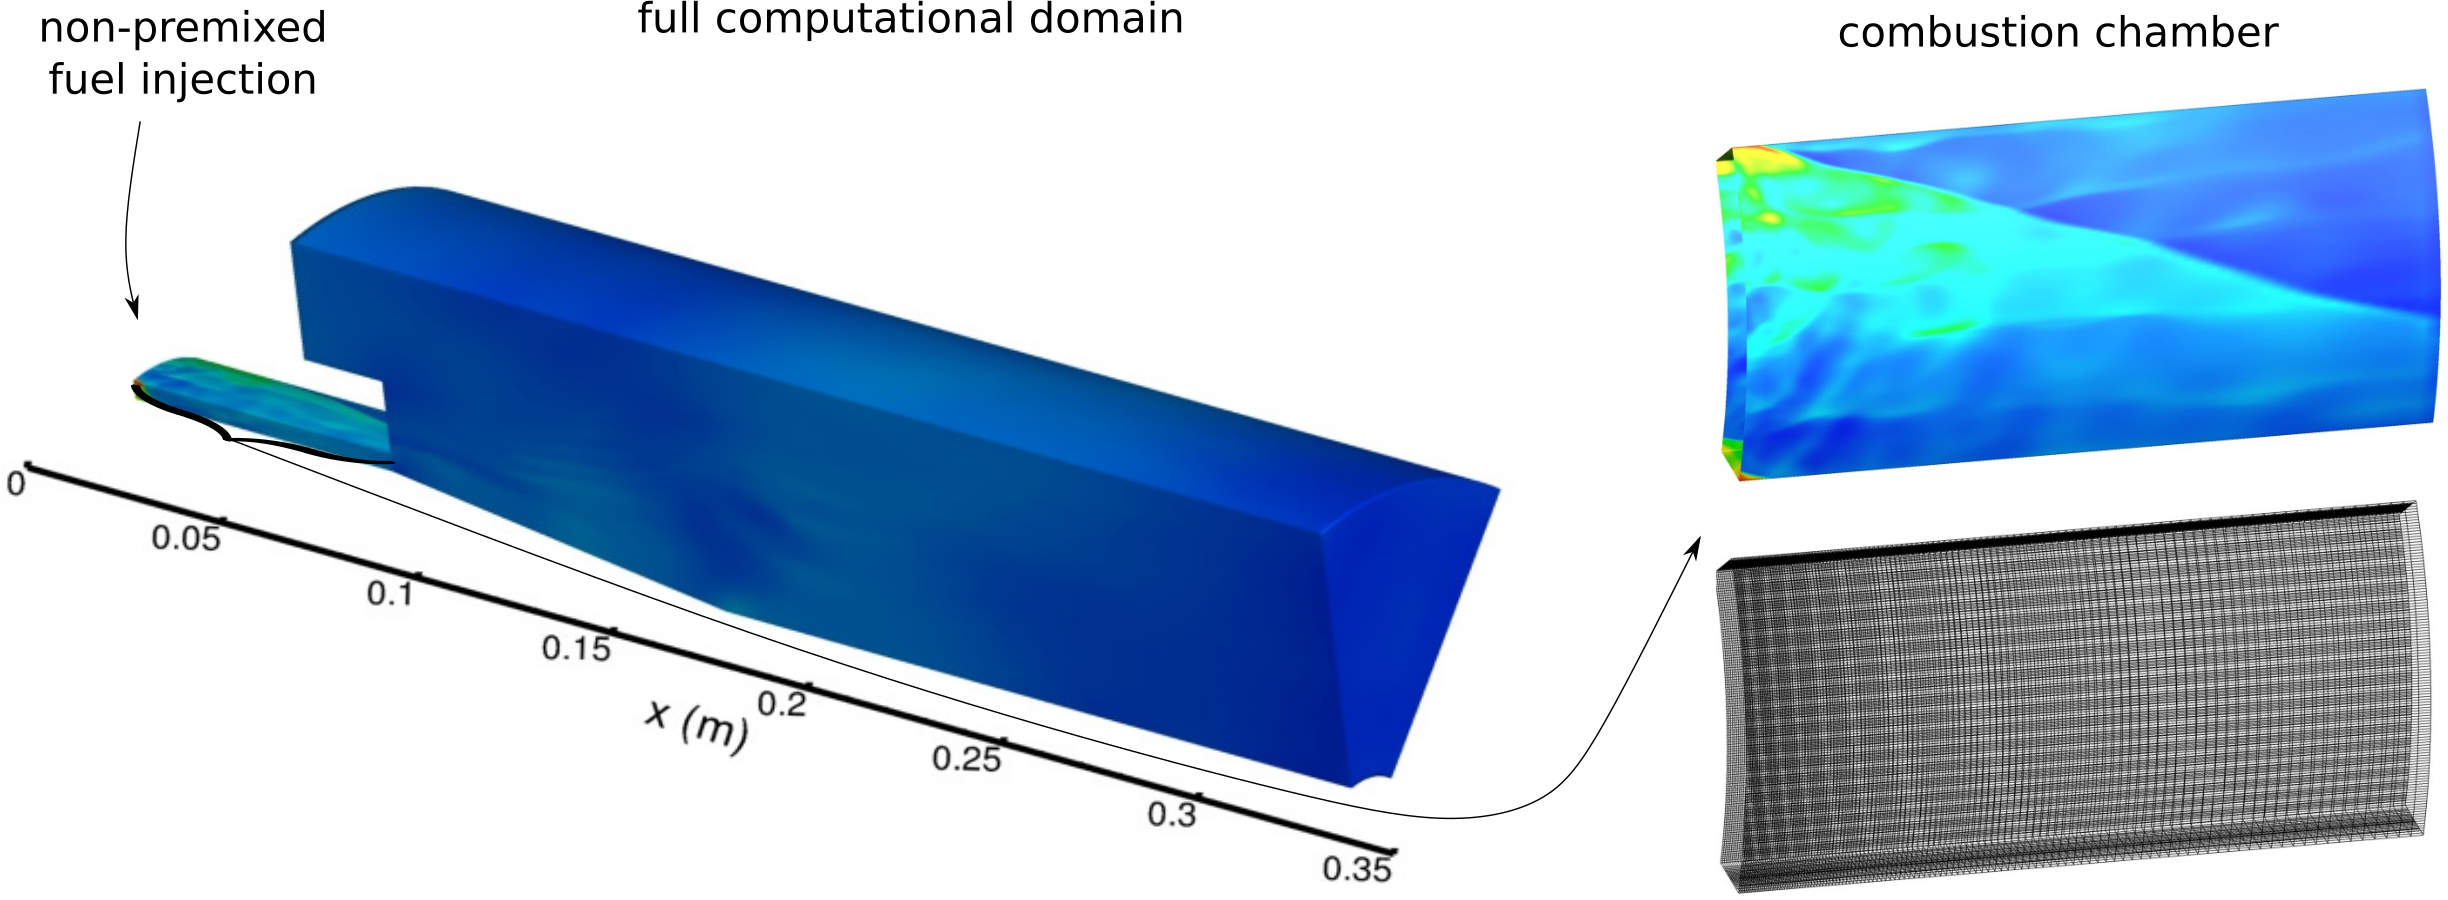

## Numerical discretization
* ### spatial discretization uses a second-order McCormack finite-volume scheme and a second-order central difference viscous term
* ### the full computational domain comprises about $9.9\textrm{M}$ spatial DoF
* ### the results are evolved in time using a second order McCormack scheme as well
* ### the time steps were computed dynamically
* ### the time step in the (quasi-)steady-state regime is $\Delta t \approx 1.2 \times 10^{-9}$ seconds

# Step 1: Acquiring training data
* ### 2 ms of real-time simulation of the full system were obtained using $100,000$ CPU hours on $1,672$ cores
* ### here, we are interested in modeling the combustion chamber only 
* ### the chamber gap width is 5.0 mm, while both the outer diameter and length measure 76.0 mm
* ### the original combustion chamber data was interpolated onto a structured grid with $n_x = 314,874$ DoF
* ### we have a total of $441$ down-sampled time instants from the high-fidelity simulation over time interval $[0.9933 \times 10^{-3}, 1.3756 \times 10^{-3}]$ seconds
* ### we use the first $n_t = 294$ snapshots over time interval $[0.9933 \times 10^{-3}, 1.2488 \times 10^{-3}]$ seconds for training (i.e., $2/3$ of the total number of available snapshots) and the remaining $147$ ($1/3$ of the total) for predictions beyond the training horizon

# Step 2: Training data manipulation
## Step 2.1: Lifting
* ### the governing equations do not have the desired polynomial structure in the original variables
* ### to this end, we transform the data snapshots to represent the following $n_w=12$ state variables $$w = [1/\rho \ \ p \ \  v_x \ \ v_y \ \ v_z \ \ w_{\mathrm{CH_4}} \ \ w_{\mathrm{O_2}} \ \ w_{\mathrm{H_2O}} \ \ w_{\mathrm{CO_2}} \ \ w_{\mathrm{H_2}} \ \ w_{\mathrm{CO}} \ \ T]^\top,$$ where $1/\rho \ [\mathrm{m}^{3} \cdot \mathrm{kg}^{-1}]$ is specific volume, $p \ [\mathrm{Pa}]$ is pressure, $v_x, v_y, v_z \ [\mathrm{m} \cdot \mathrm{s}^{-1}]$ are the three velocity components, $w_{[\cdot]}$ are the species mass fractions of the six chemical species $\mathrm{CH_4}$, $\mathrm{O_2}$, $\mathrm{H_2O}$, $\mathrm{CO_2}$, $\mathrm{H_2}$ and $\mathrm{CO}$, and $T \ [\textrm{K}]$ is temperature 
* ### the dimension of the transformed data snapshots is therefore $$n = n_x \times n_w =  314,874 \times 12 = 3,778,488$$
* ### this transformation makes most terms in the governing equation linear and quadratic
* ### we can therefore approximate the dynamics of the state evolution as a quadratic dynamical system $$ \frac{\mathrm{d}\textbf{w}}{\mathrm{d}t} = \textbf{A} \textbf{w} + \textbf{H} (\textbf{w} \otimes \textbf{w}), \quad \textbf{A} \in \mathbb{R}^{3,778,488 \times 3,778,488}, \textbf{H} \in \mathbb{R}^{3,778,488 \times 3,778,488^2}$$
* ### we collect the $n_t = 294$ training snapshots of the transformed variables into the snapshot matrix $$\textbf{W} \in \mathbb{R}^{3,778,488 \times 294}$$ 
* ### extrema of the $n_w=12$ transformed variables

| state variable | minimum value | maximum value |
| :---        |    :----:   |          ---: |
| specific volume | $0.6285$ | $6.3212$ |
| pressure  | $0.2140 \times 10^6$ | $ 1.1406 \times 10^6$ |
| x-velocity | $-64.8222$ | $ 1397.0931$ |
| y-velocity | $-531.4510$ | $ 529.4986$ |
| z-velocity | $-985.0364$ | $ 812.2877$ |
| $\mathrm{CH_4}$ mass fraction | $0.0000$ | $0.5376$ |
| $\mathrm{O_2}$ mass fraction | $1.6077 \times 10^{-6}$ | $ 0.6163$ |
| $\mathrm{H_2O}$ mass fraction | $0.0767$ | $ 0.4399$ |
| $\mathrm{CO_2}$ mass fraction | $0.0045$ | $0.2842$ |
| $\mathrm{H_2}$ mass fraction | $0.0008$ | $0.0551$ |
| $\mathrm{CO}$ mass fraction | $0.0650$ | $0.5731$ |
| temperature | $762.4429$ | $3410.2900$ |

    
## Step 2.2: Centering and scaling
* ### since the $n_w = 12$ transformed state variables have significantly different scales, we center and scale the snapshot data variable-by-variable prior to constructing the reduced model
### Step 2.2.1: Centering $$\textbf{W}_{\textrm{cen}} = \textbf{W} - \textbf{W}_{\textrm{ref}},$$
### where $\textbf{W}_{\textrm{ref}} \in \mathbb{R}^{3,778,488}$ comprises the mean field (over the training data) of all transformed variable
### Step 2.2.2: Scaling $$\textbf{Q} = \textrm{scale}(\textbf{W}_{\textrm{cen}})$$
### is done by dividing by the maximum absolute value of each transformed variable, which ensures that the scaled variables do not exceed $[-1, 1]$

### in python 

```python
import numpy as np

n_x = 314874 # number of spatial DoF
n_w = 12 # number of transformed state variables

S = load(training_data) # load training data in the original variables
W = lift(S) # transform training data; the shape of W is n x n_t

W_ref = np.mean(W, axis=1) # compute the mean field of all transformed variable
W_cen = W - W_ref[:, np.newaxis] # center the transformed training data

# center and scale the transformed snapshot data variable-by-variable
Q               = np.zeros_like(W)
scaling_factors = np.zeros(n_w)
for i in range(n_w):
    scaling_factors[i]      = np.max(np.abs(W_cen[i*n_x : (i+1)*n_x, :]))
    Q[i*n_x : (i+1)*n_x, :] = W_cen[i*n_x : (i+1)*n_x, :]/scaling_factors[i]
```

# Step 3: Compute the POD basis
* ### we compute the POD basis from the thin singular-value decomposition (SVD) of the centered and scaled snapshot matrix $$ \mathbf{Q} = \mathbf{V} \mathbf{\Sigma} \mathbf{U}^\top, $$
### where $\mathbf{V} \in \mathbb{R}^{3,778,488 \times 294}$, $\mathbf{\Sigma} \in \mathbb{R}^{294 \times 294}$, and $\mathbf{U} \in \mathbb{R}^{294 \times 294}$

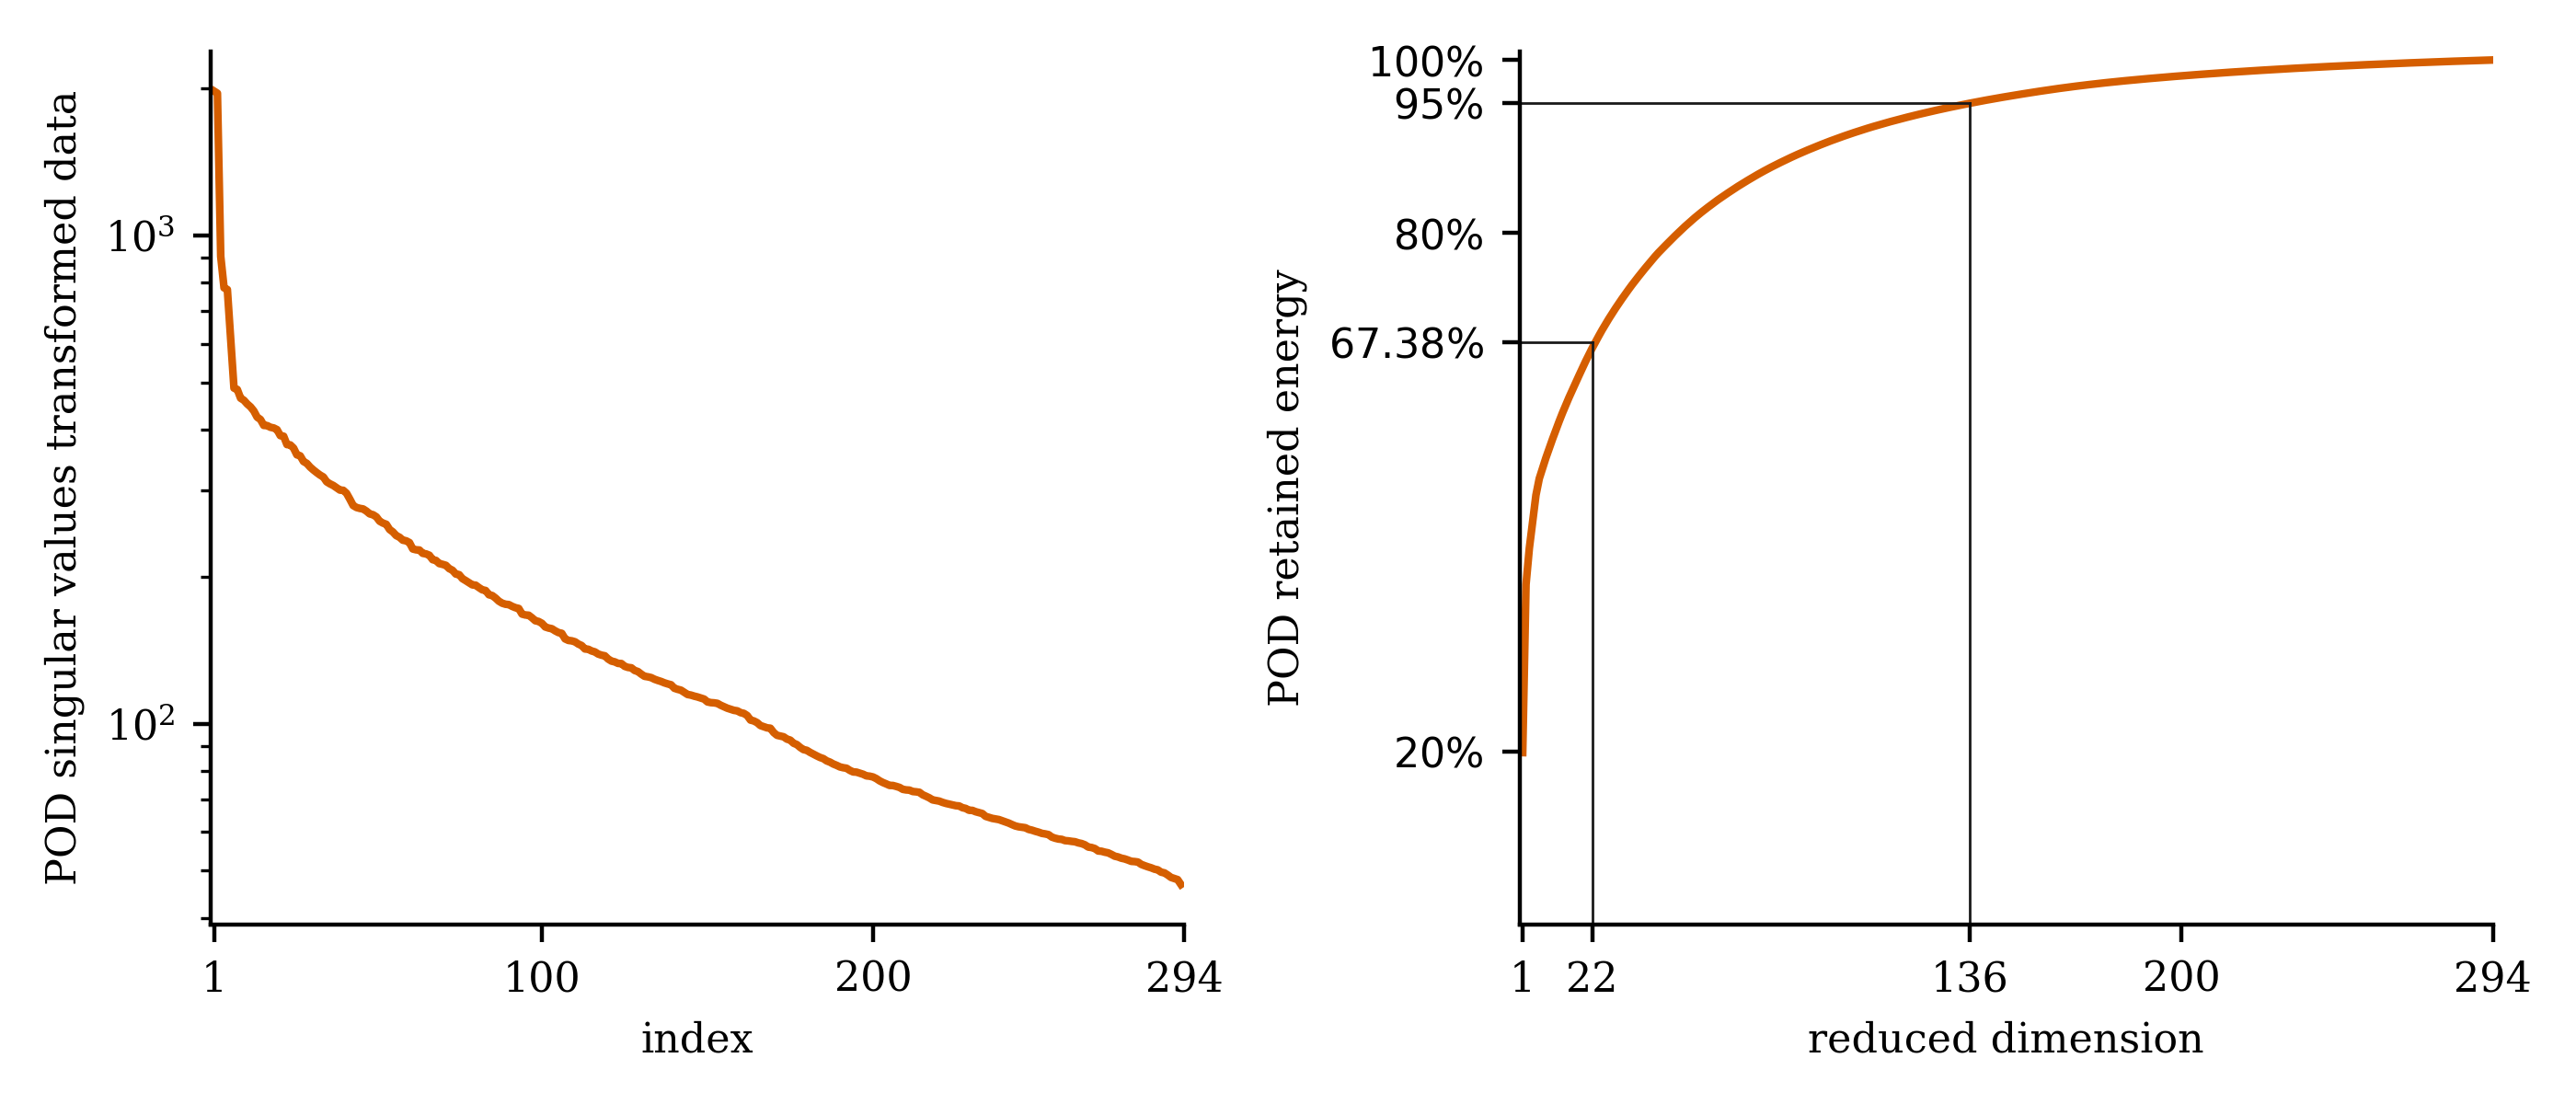

* ### due to the sparsity of the training data set, the maximum reduced dimension for a quadratic OpInf reduced model is $r = 22$
* ### the POD basis $\mathbf{V}_r \in \mathbb{R}^{3,778,488 \times 22}$ therefore comprises the first $22$ left singular values corresponding to the largest $22$ singular values
### in python 

```python
r = 22 # maximum reduced dimension for a qudratic OpInf reduced model

V, Sigma, _ = np.linalg.svd(Q, full_matrices=False) # V comprises the left singular vectors and Sigma the singular values in non-decreasing order

V_r = V[:, :r] # POD basis of size r
```
* ### in the following, we will infer an OpInf reduced model with reduced dimension $r=22$, i.e., a reduction of more than $1.7 \times 10^5$ compared to the full dimension

# Step 4: Project transformed snapshots
* ### we project $\textbf{Q}$ onto the linear subspace spanned by the column vectors of $\mathbf{V}_r$: $$\hat{\textbf{Q}} = \mathbf{V}_r^{\top} \textbf{Q} \in \mathbb{R}^{22 \times 294}$$
### in python
``` python
Qhat = V_r.T @ Q
```

# Step 5: Infer the reduced operators
* ### since the training data set is sparse, we will consider a fully discrete reduced model
* ### the fully discrete quadratic reduced model that we will construct via OpInf reads $$ \hat{\textbf{q}}[k + 1] = \hat{\textbf{A}} \textbf{q}[k] + \hat{\textbf{H}} (\hat{\textbf{q}}[k] \otimes \hat{\textbf{q}}[k]) + \hat{\textbf{c}}, \quad \hat{\textbf{A}} \in \mathbb{R}^{22 \times 22}, \hat{\textbf{H}} \in \mathbb{R}^{22 \times 22^2}, \hat{\textbf{c}} \in \mathbb{R}^{22}$$
* ### to infer the reduced operators $\hat{\textbf{A}}, \hat{\textbf{H}}, \hat{\textbf{c}}$, we must solve the following regularized linear least-squares minimization problem $$\mathrm{argmin}_{\hat{\textbf{A}}, \hat{\textbf{H}}, \hat{\textbf{c}}} \left\lVert \hat{\mathbf{Q}}_1^\top\hat{\textbf{A}}^{\top} + \left(\hat{\mathbf{Q}}_1 \otimes \hat{\mathbf{Q}}_1\right)^\top \hat{\textbf{H}}^\top + \textbf{1}_{n_t - 1} \hat{\textbf{c}} - \hat{\mathbf{Q}}_2^\top \right\rVert_F^2 + \lambda_{\ell} \left( \left\lVert \hat{\mathbf{A}}\right\rVert_F^2 + \left\lVert \hat{\mathbf{c}}\right\rVert_F^2 \right) + \lambda_q \left\lVert \hat{\mathbf{H}}\right\rVert_F^2,$$
### where:
    * ### $\hat{\mathbf{Q}}_{1} =
     \begin{bmatrix}
\vert & \vert & & \vert\\
     \hat{\mathbf{q}}_1 &
     \hat{\mathbf{q}}_2 &
     \ldots &
     \hat{\mathbf{q}}_{293}\\
     \vert & \vert & & \vert
     \end{bmatrix}, \quad 
     \hat{\mathbf{Q}}_{2} =
     \begin{bmatrix}
\vert & \vert & & \vert\\
     \hat{\mathbf{q}}_2 &
     \hat{\mathbf{q}}_3 &
     \ldots &
     \hat{\mathbf{q}}_{294}\\
     \vert & \vert & & \vert
     \end{bmatrix}$
    * ### F denotes the Frobenius norm
    * ### $\lambda_{\ell}, \lambda_{q} \in \mathbb{R}$ are scalar regularization hyperparameters

## Step 5.1: Determining the optimal values of the regularization hyperparameters

In [ ]:
from utils.utils import *

r            = 22 # reduced dimension
n_steps      = 441 # number of steps to integrate the discrete reduced models
n_t          = 294 # number of snapshots used for training

lambda_lin_all   = np.logspace(-2., 5., num = 20) # candiate hyperparameter for the linear and const reduced operators
lambda_quad_all  = np.logspace(6., 12., num = 20) # candiate hyperparameter for the quadratic reduced operator

Qhat = np.load('data/Qhat.npy') # load projected (centered and scaled) data matrix

print('Shape of projected (centered and scaled) data matrix {}'.format(Qhat.shape))

In [ ]:
Qhat_1 = Qhat[:-1, :] # projected data matrix used to obtain the left-hand side of the OpInf learning problem
Qhat_2 = Qhat[1:, :] # projected data matrix used to obtain the right-hand side of the OpInf learning problem

s         = int(r*(r + 1)/2) # number of unique DoF corresponding to one column of the quadratic reduced operator
OpInf_dof = r + s + 1 # number of DoF corresponding to one column of all reduced operators to be inferred

Qhat_1_sq = get_x_sq(Qhat_1) # projected data matrix corresponding to the quadratic reduced operator
E         = np.ones((n_t - 1, 1)) # data matrix corresponding to the constant reduced operator

D    = np.concatenate((Qhat_1, Qhat_1_sq, E), axis=1) # data matrix in the OpInf learning problem
D_sq = D.T @ D

print('The shape of the data matrix is {}'.format(D.shape))

D_rank = np.linalg.matrix_rank(D)
print('The (column) rank of OpInf data matrix = {}'.format(D_rank))
assert(D_rank <= D.shape[0]) # we do not want to overparametrize the least-squares minimization problem

In [ ]:
Qhat_mean       = np.mean(Qhat, axis=0)
dev             = Qhat - Qhat_mean
Qhat_maxdiff    = np.max(np.abs(dev)) # max projected data deviation over training

max_growth = 1.2 # we will consider all candidate regularization hyperparameters for which the OpInf predictions 
                 # are at most 20% larger than the projected training data  

Ahat_best = None
Fhat_best = None
chat_best = None 

lambda_lin_best  = 1e20
lambda_quad_best = 1e20

err_train_best = 1e20

for n, lambda_lin in enumerate(lambda_lin_all): # loop over candidate hyperparameters for the linear and constant red op
    for m, lambda_quad in enumerate(lambda_quad_all): # loop over candidate hyperparameters for the quadratic red op

        regg            = np.zeros(OpInf_dof)
        regg[:r]        = lambda_lin
        regg[r:r + s]   = lambda_quad # we regularize the quadratic reduced operator differently
        regg[r + s:]    = lambda_lin 
        regularizer     = np.diag(regg)
        D_reg           = D_sq + regularizer

        Ohat = np.linalg.solve(D_reg, D.T @ Qhat_2).T # solve the OpInf least-squares minimization problem by  
                                                      # solving the (regularized) normal equation
        
        Ahat = Ohat[:, :r]
        Fhat = Ohat[:, r:r + s]
        chat = Ohat[:, r + s]

        OpInf_dyn_system = lambda x: Ahat @ x + Fhat @ get_x_sq(x) + chat
        
        Qhat_init             = Qhat_1[0, :] # initial condition for the reduced discrete quadratic dynamical system
         # solve the reduced discrete dynamical quadratic system over the entire (training + prediction) time horizon
        is_nan, Qhat_OpInf    = evolve_opinf_difference_model(Qhat_init, n_steps, OpInf_dyn_system)
        Qhat_OpInf            = Qhat_OpInf.T
        
        err_train_per_step = get_err(Qhat[:n_t, :], Qhat_OpInf[:n_t, :]) # compute training error
        max_dev_per_step   = np.max(np.max(np.abs(Qhat_OpInf - Qhat_mean), axis=0)) # max deviation from the mean
        
        POD_coeff_growth = max_dev_per_step/Qhat_maxdiff # max growth compared to the projected training data

        if POD_coeff_growth <= max_growth:
            if err_train_per_step < err_train_best:
                
                err_train_best = err_train_per_step

                lambda_lin_best  = lambda_lin
                lambda_quad_best = lambda_quad

                Ahat_best = Ahat.copy()
                Fhat_best = Ahat.copy()
                chat_best = chat.copy()

print('Optimal lambda_l = {}'.format(lambda_lin_best))
print('Optimal lambda_q = {}'.format(lambda_quad_best))

## Step 5.2: Infer the reduced operators using the optimal regularization hyperameters

In [ ]:
%%timeit

regg            = np.zeros(OpInf_dof)
regg[:r]        = lambda_lin_best # we use the optimal regularization hyperparameters
regg[r:r + s]   = lambda_quad_best # we use the optimal regularization hyperparameters
regg[r + s:]    = lambda_lin_best # we use the optimal regularization hyperparameters
regularizer     = np.diag(regg)
D_reg           = D_sq + regularizer

Ohat = np.linalg.solve(D_reg, D.T @ Qhat_2).T

Ahat = Ohat[:, :r]
Fhat = Ohat[:, r:r + s]
chat = Ohat[:, r + s]

OpInf_dyn_system = lambda x: Ahat @ x + Fhat @ get_x_sq(x) + chat

Qhat_init             = Qhat_1[0, :]
is_nan, Qhat_OpInf    = evolve_opinf_difference_model(Qhat_init, n_steps, OpInf_dyn_system, verbose=True)

# Postprocessing
* ### after the OpInf reduced solution is computed over the full time horizon (training and prediction), we can map it back to the original coordinates
* ### we begin by computing $$ \textbf{Q}_{\mathrm{OpInf}} = \textbf{V}_r \hat{\textbf{Q}}_{\mathrm{OpInf}} \in \mathbb{R}^{3,778,488 \times 441}$$
* ### we then unscale $\textbf{Q}_{\mathrm{OpInf}}$ as $$ \textbf{W}_{\mathrm{cen}, \mathrm{OpInf}} =  \mathrm{unscale}(\textbf{Q}_{\mathrm{OpInf}} )  \in \mathbb{R}^{3,778,488 \times 441} $$
* ### lastly, we add the mean field to $\textbf{Q}_{\mathrm{OpInf}}$ to obtain $$ \textbf{W}_{\mathrm{OpInf}} =  \textbf{W}_{\mathrm{ref}} + \textbf{W}_{\mathrm{cen}, \mathrm{OpInf}}  \in \mathbb{R}^{3,778,488 \times 441}$$
### in python 

```python
Q_OpInf = V_r @ Qhat_OpInf

W_cen_OpInf = np.zeros_like(Q_OpInf)
for i in range(n_s):
    W_cen_OpInf[i*n_x : (i+1)*n_x, :] = Q_OpInf[i*n_x : (i+1)*n_x, :]*scaling_factors[i]

W_OpInf = W_cen_OpInf + W_ref
```

* ### the figure below plots the comparison between the pressure obtained using the reduced model solution and the reference pressure at two mid-channel probe locations
    * #### probe 1: (0.0100, 0.0352, 0.0) (close to the injectors)
    * #### probe 2: (0.0400, 0.0352, 0.0) (further away from the injectors)

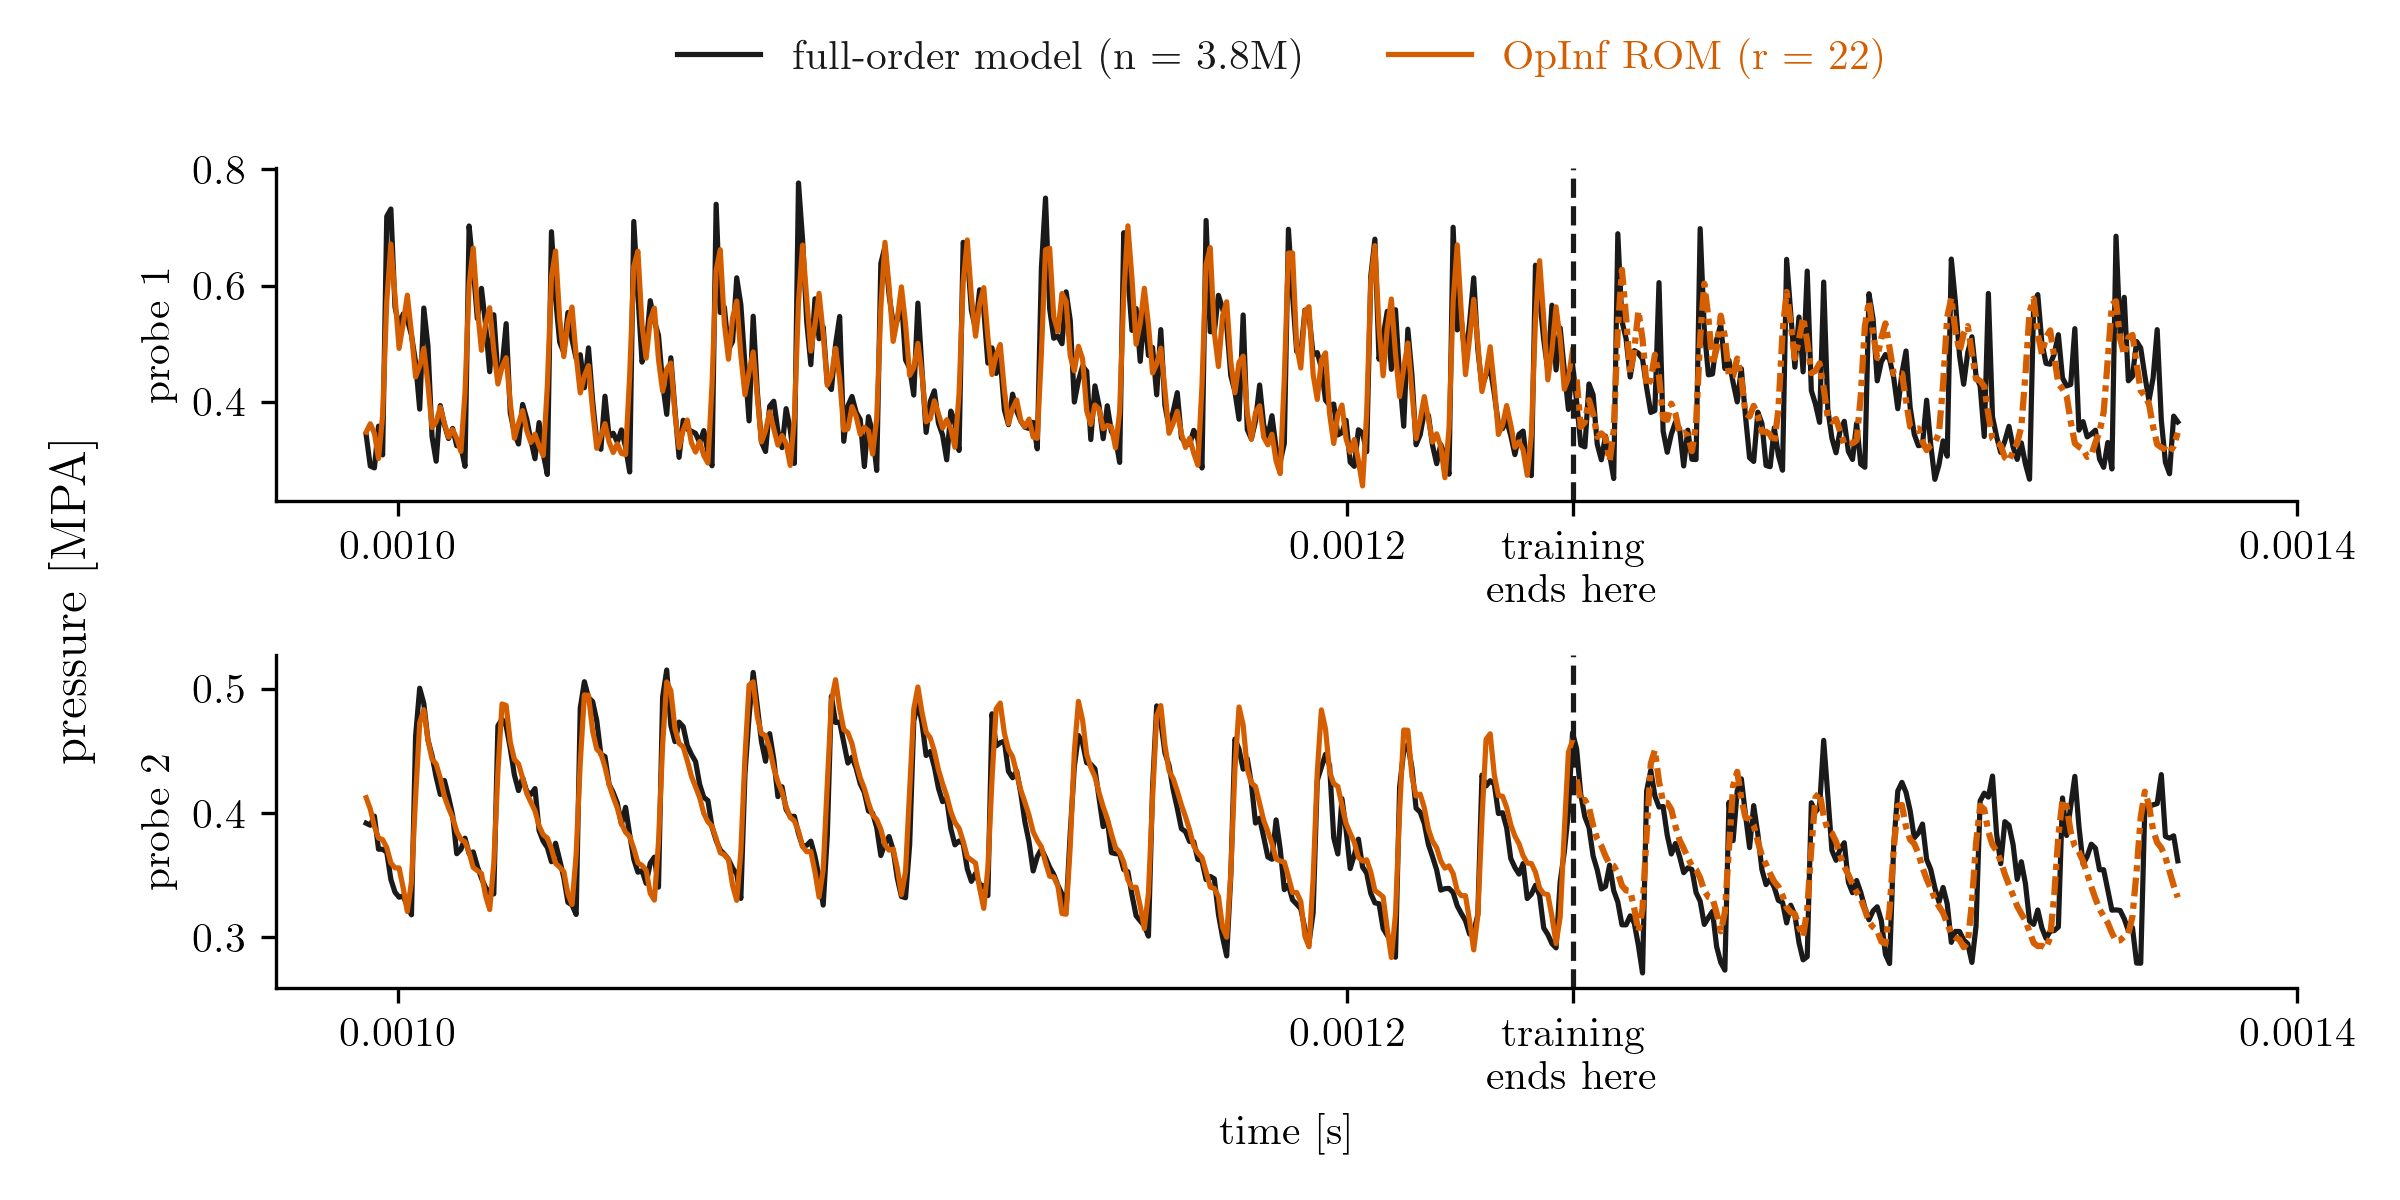